<h1 align='center'>Environment Canada Weather Data Notebook Demo Part 2</h1>

In this note book, we will create an animated heat map to show the changes in monthly temperature throughout Ontario from February 2017 to January 2019. The data is captured identically as it was in part 1 of this series, however, in the interest of time we have aggregated it by month and prepared this data set in advance. This notebook will show you how to use open data to create interesting time-dependent animations of temperature patterns, as well as demonstrate how different ways of filling in missing data between weather stations can _drastically_ affect the presentation of data and potential interpretations of that data. 



To begin, we import some packages that we will be using for this notebook. We also download our custom helper functions for this notebook in the `notebook_code/map_helpers.py` file.

In [ ]:
# need to install packages to create maps!
!pip install descartes --user

In [1]:
import pandas as pd
from notebook_code.map_helpers import make_spline, plot_instance, animate_map, exclude_mesh, reanimator

import matplotlib.pyplot as plt 
from IPython.display import HTML
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter("ignore")

%matplotlib inline



<h2 align='center'> Gathering Ontario's Weather Data</h2>

In the next cell, we download a csv file of Ontario weather station data that we have aggregated by month. The temperature data has been aggregated such that we only display the average monthly temperature, rather than the houry variations in the previous data set.  

In [28]:

file_url = "https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/callysto-open-data/OntarioTempMonthly.csv"
monthly = pd.read_csv(file_url)
# Remove superfluous colomn. 
del monthly['Unnamed: 0']
monthly.head()


Station Name         UTC    Year     Month        Day  \
0  ALGONQUIN PARK EAST GATE  2017-01-31  2017.0  1.000000  15.898512   
1  ALGONQUIN PARK EAST GATE  2017-02-28  2017.0  1.992560  14.522321   
2  ALGONQUIN PARK EAST GATE  2017-03-31  2017.0  2.993280  16.005376   
3  ALGONQUIN PARK EAST GATE  2017-04-30  2017.0  3.994444  15.505556   
4  ALGONQUIN PARK EAST GATE  2017-05-31  2017.0  4.994616  16.012113   

   Temp (°C)  Temp Flag  Dew Point Temp (°C)  Rel Hum (%)  Wind Dir (10s deg)  \
0  -6.969147        NaN            -9.177131    84.492558           18.455036   
1  -6.433780        NaN           -10.004911    77.666667           20.303797   
2  -7.167339        NaN           -13.261425    65.971774           19.267148   
3   4.177917        NaN            -0.936250    73.991667           17.195462   
4   9.568910        NaN             4.465545    74.362046           17.691769   

   Wind Spd (km/h)  Visibility (km)  Stn Press (kPa)  Wind Chill  \
0         3.408660              NaN        96.410176   -8.110429   
1         3.797619              NaN        96.236920  -10.093394   
2         4.072581              NaN        97.095565  -11.402532   
3         3.955556              NaN        96.744819   -3.166667   
4         3.973082              NaN        96.384132   -1.903226   

   Wind Chill Flag  Latitude  Longitude  Elevation  
0              NaN     45.53     -78.27      397.0  
1              NaN     45.53     -78.27      397.0  
2              NaN     45.53     -78.27      397.0  
3              NaN     45.53     -78.27      397.0  
4              NaN     45.53     -78.27      397.0

In [3]:
# Find out how many weather stations we have data for
len(monthly["Station Name"].unique())


75

Where we see that the first station we have data for is ALGONQUIN PARK EAST GATE, and we have data from 75 weather stations from across Ontario. 

Before we can create a useful heat map, we need to obtain a map of Canada so we can have a basis on which to create our map. This is done using a shape file of Canada provided by ArcGis at [the following link](https://www.arcgis.com/home/item.html?id=dcbcdf86939548af81efbd2d732336db). This data is downloaded and extracted below. 



In [32]:
# Download shape file from a zip. 
zip_url = 'https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/callysto-open-data/Canada.zip'
import requests, zipfile, io
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("Canada")

In [4]:
# Need to get the lat/long tracing of Ontario 
shape = gpd.read_file('Canada/Canada.shp')
# Convert the projection of the map to a more intuitive "natural" projection of lat/long
shape = shape.to_crs(epsg=4326)




Where we notice that our shape file has `POLYGON` entries in the geometry column. These are the Longitude/Latitude coordinates that define the boundaries of the provinces. These are known as "shape files" which define the shape of geographic boundaries. We can use pandas to plot this shape file to check that we have the appropriate map

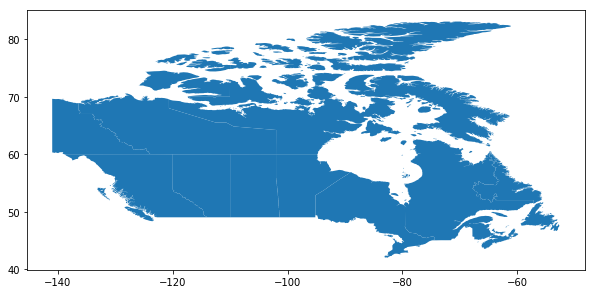

In [5]:
shape.plot(figsize = (10,10))


Where that certainly looks like we've captured the map of Canada! Our next step is to filter this down to just Ontario for the purposes of creating our animation. This is done as follows

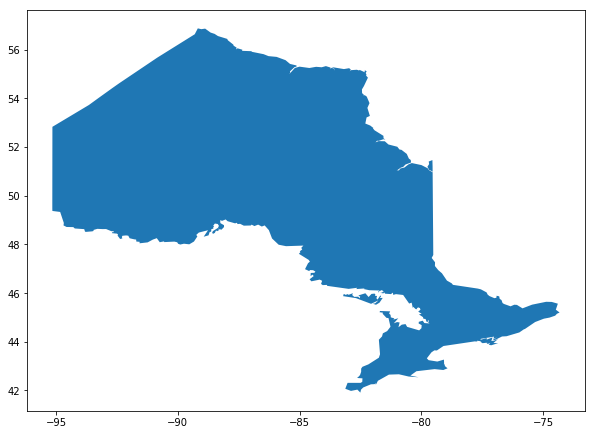

In [6]:
# NAME is the name of the column header 
ont = shape[shape.NAME=="Ontario"]['geometry']
ont.plot(figsize = (10,10))


Where we now have a boundary that readily defines the boundaries of Ontario. 

<h3 align='center'> Optional Exercise </h3>

Try plotting the shape of other provinces and territories in the cell below


In [7]:
print("These are all the names of provinces/territories you can take a peek at ")
list(shape.NAME)

These are all the names of provinces/territories you can take a peek at 


['Quebec',
 'Nova Scotia',
 'Saskatchewan',
 'Alberta',
 'Newfoundland and Labrador',
 'British Columbia',
 'New Brunswick',
 'Prince Edward Island',
 'Yukon Territory',
 'Manitoba',
 'Ontario',
 'Nunavut',
 'Northwest Territories']

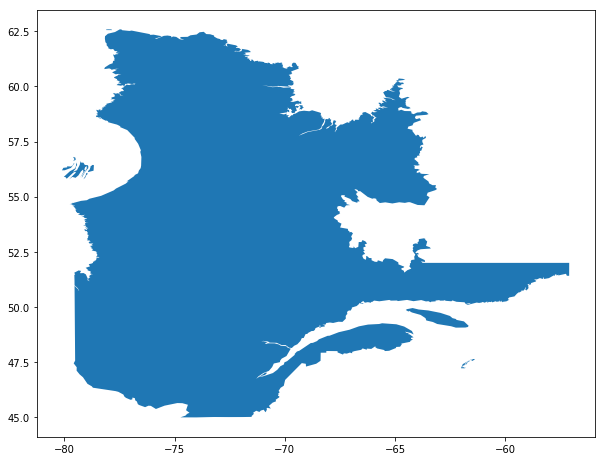

In [8]:
shape[shape.NAME=="Quebec"]['geometry'].plot(figsize = (10,10))

The next step to creating an animated heat map is to create an equally spaced grid of Longitude and Latitude coordinates which will allow us to define a "box" on which to plot our heat map. This is done quite easily by simply grabbing all the unique latitude and longitude pairs of the weather station data. This is done below. 

**Note** you can increase the resolution of the animations we're going to create to make more appealing plots. However, note that doubling the resolution multiplies the computational time required by four. 

In [9]:
# Latitude data
x = np.array(monthly.groupby('Station Name').mean()['Latitude'].unique())
# Longitue data
y = np.array(monthly.groupby('Station Name').mean()['Longitude'].unique())

# Change this later for higher resolution plots, but you may have to be patient! 
# Note: This is the number of pixels in the x and y directions we'll create 

resolution = 50

# Now we create an equally spaced list with a number resolution of points within our lat/long range
x_grid = np.linspace(x.min(), x.max(), resolution)
# Here we're not using the max as there is some "bad data" in the data set with incorrect coordinates! 
y_grid = np.linspace(y.min(), sorted(y)[-2], resolution)

x_grid



array([42.03      , 42.3155102 , 42.60102041, 42.88653061, 43.17204082,
       43.45755102, 43.74306122, 44.02857143, 44.31408163, 44.59959184,
       44.88510204, 45.17061224, 45.45612245, 45.74163265, 46.02714286,
       46.31265306, 46.59816327, 46.88367347, 47.16918367, 47.45469388,
       47.74020408, 48.02571429, 48.31122449, 48.59673469, 48.8822449 ,
       49.1677551 , 49.45326531, 49.73877551, 50.02428571, 50.30979592,
       50.59530612, 50.88081633, 51.16632653, 51.45183673, 51.73734694,
       52.02285714, 52.30836735, 52.59387755, 52.87938776, 53.16489796,
       53.45040816, 53.73591837, 54.02142857, 54.30693878, 54.59244898,
       54.87795918, 55.16346939, 55.44897959, 55.7344898 , 56.02      ])

<h2 align='center'> Wait - a square grid? I thought we were making a map! </h2>

Fair point! In this case the reason being is it's _very_ difficult to do 'realistic' heat maps on non-square grids. But that's okay! We can create a mask, or a list of data points that we should remove from our visualization. In our case, let's create a mask which will exclude all points on our grid that don't fall within our map of Ontario. This is done with a function we've abstracted away into a helper file which we call below. 

In [10]:
# This only needs to be run once at any resolution you try. 
mask = exclude_mesh(x_grid, y_grid, geometry=ont)
mask



array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Where it's really hard to tell what our mask looks like with a bunch of true false values sticking around. However, we can plot our mask to see if it worked, which is done below.

(-0.5, 49.5)

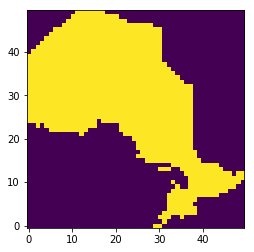

In [11]:
plt.imshow(mask)
ax = plt.gca()
# This data comes out reversed, so we need to flip it!
ax.set_ylim(ax.get_ylim()[::-1])

Where in the plot above, yellow represents true meaning we'll plot data within those pixels, and, what we'll call a dark mauve represents false which means we won't plot data in those pixels. 

## Creating an Animation

In the cell below we create our animation with the `reanimator` function from our helper file. This will take in our grid and resolution, as well as our mask in order to create the map. 

**Note:** Creating these animations may take a minute or two, but they are well worth the wait!

In [19]:
# Define our figure
fig, ax = plt.subplots(figsize=(14,10))

#Define which months to plot 
m_list = list(monthly['UTC'].unique())

# change 'radial' to either 'smooth' or 'nearest' to see the differences in interpolation
ani = reanimator('smooth', m_list, monthly, x_grid, y_grid, mask, ax, fig)

# display the animation 
HTML(ani.to_jshtml())


In the cell above (or in a new cell) create other animations with different interpolations. Your options are a smooth interpolation called with 
```python
ani = reanimator('smooth', m_list, monthly, x_grid, y_grid, mask, ax, fig)
```

or a nearest neighbor interpolation called with 
```python
ani = reanimator('nearest', m_list, monthly, x_grid, y_grid, mask, ax, fig)
```

It is currently set to a radial interpolation where the program tries to fill in missing data by assuming radial functions describe how the data should evolve to the next point.

## Things to think about:

1. When you change the interpolation function, notice how the heat map is incredibly different. Would it be easy to mislead someone by choosing/fine tuning your interpolation function? 

2. Time permitting, change the resolution of this animation. Does it affect the interpolation and affect your interpretation of the data? 

2. Is static weather station data the best data source to create animations like this? Is there a reason modern meteorologists rely on satellite and radar data more heavily than weather station data for large-scale predictions? Why or why not? 

<h2 align='center'> Plotting Daily Averages </h2>

Things get a little more interesting if we view a data set with a smaller time aggregation. In the animation below we view November 2017 in 12 hour intervals to see how the temperature has changed according to these 12 hour averages. The process and functions to create the map is the same - we just have to change the data set accordingly. 

In [30]:
file_url = "https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/callysto-open-data/ontario_november_12H.csv"

day = pd.read_csv(file_url)
day.head()

Unnamed: 0              Station Name                        UTC  \
0           0  ALGONQUIN PARK EAST GATE  2017-11-01 00:00:00+00:00   
1           1  ALGONQUIN PARK EAST GATE  2017-11-01 12:00:00+00:00   
2           2  ALGONQUIN PARK EAST GATE  2017-11-02 00:00:00+00:00   
3           3  ALGONQUIN PARK EAST GATE  2017-11-02 12:00:00+00:00   
4           4  ALGONQUIN PARK EAST GATE  2017-11-03 00:00:00+00:00   

   Unnamed: 0.1  Unnamed: 0.1.1    Year      Month       Day  Temp (°C)  \
0        7298.0          7298.0  2017.0  10.727273  9.181818  -0.781818   
1        7309.5          7309.5  2017.0  11.000000  1.000000   3.008333   
2        7321.5          7321.5  2017.0  11.000000  1.666667   2.533333   
3        7333.5          7333.5  2017.0  11.000000  2.000000   6.341667   
4        7345.5          7345.5  2017.0  11.000000  2.666667   7.433333   

   Temp Flag  ...  Rel Hum (%)  Wind Dir (10s deg)  Wind Spd (km/h)  \
0        NaN  ...    95.000000            5.333333         0.272727   
1        NaN  ...    81.166667           15.272727         3.000000   
2        NaN  ...    93.416667            8.250000         2.500000   
3        NaN  ...    93.583333           13.100000         2.000000   
4        NaN  ...    92.500000           27.200000         3.000000   

   Visibility (km)  Stn Press (kPa)  Wind Chill  Wind Chill Flag  Latitude  \
0              NaN        97.179091        -1.5              NaN     45.53   
1              NaN        97.339167         NaN              NaN     45.53   
2              NaN        97.087500         NaN              NaN     45.53   
3              NaN        96.679167         NaN              NaN     45.53   
4              NaN        96.590000         NaN              NaN     45.53   

   Longitude  Elevation  
0     -78.27      397.0  
1     -78.27      397.0  
2     -78.27      397.0  
3     -78.27      397.0  
4     -78.27      397.0  

[5 rows x 21 columns]

In [14]:
# Latitude data
x2 = np.array(day.groupby('Station Name').mean()['Latitude'].unique())
# Longitue data
y2 = np.array(day.groupby('Station Name').mean()['Longitude'].unique())

# Change this later for higher resolution plots, but you may have to be patient! 
# Note: This is the number of pixels in the x and y directions we'll create 

resolution = 50

# Now we create an equally spaced list with 100 points within our lat/long range
x_grid2 = np.linspace(x.min(), x.max(), resolution)
# Here we're not using the max as there is some "bad data" in the data set with incorrect coordinates! 
y_grid2 = np.linspace(y.min(), sorted(y)[-2], resolution)

mask2 = exclude_mesh(x_grid, y_grid, geometry=ont)


In [20]:
# Define our figure
fig, ax = plt.subplots(figsize=(14,10))

#Define which months to plot 
m_list2 = list(day['UTC'].unique())

# change 'radial' to either 'smooth' or 'nearest' to see the differences in interpolation
ani2 = reanimator('smooth', m_list2, day, x_grid2, y_grid2, mask2, ax, fig, daily=True)

# display the animation 
HTML(ani2.to_jshtml())
